In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import yaml
import re
from typing import Optional
from nerfstudio.cameras.rays import RaySamples, Frustums
from nerfstudio.cameras.cameras import Cameras, CameraType

from reni.configs.reni_config import RENIField
from reni.pipelines.reni_pipeline import RENIPipeline
from reni.field_components.field_heads import RENIFieldHeadNames
from reni.data.datamanagers.reni_datamanager import RENIDataManager
from reni.utils.utils import find_nerfstudio_project_root, rot_z, rot_y
from reni.utils.colourspace import linear_to_sRGB


In [2]:
# setup config
test_mode = 'val'
world_size = 1
local_rank = 0
device = 'cuda:0'

project_root = find_nerfstudio_project_root(Path(os.getcwd()))
# set current working directory to nerfstudio project root
os.chdir(project_root)

def load_model(load_dir: Path, load_step: Optional[int] = None):
    ckpt_dir = load_dir / 'nerfstudio_models'
    def clean_and_load_yaml(yaml_content):
        # Remove !!python related tags
        cleaned_content = re.sub(r'!!python[^\s]*', '', yaml_content)
        
        # Load the cleaned content
        return yaml.safe_load(cleaned_content)

    if load_step is None:
        load_step = sorted(int(x[x.find("-") + 1 : x.find(".")]) for x in os.listdir(ckpt_dir))[-1]
    
    ckpt = torch.load(ckpt_dir / f'step-{load_step:09d}.ckpt', map_location=device)
    reni_model_dict = {}
    for key in ckpt['pipeline'].keys():
        if key.startswith('_model.'):
            reni_model_dict[key[7:]] = ckpt['pipeline'][key]
    
    config_path = load_dir / 'config.yml'
    with open(config_path, 'r') as f:
        content = f.read()
        config = clean_and_load_yaml(content)
    
    reni_field_config = RENIField.config

    reni_field_config.pipeline.datamanager.dataparser.convert_to_ldr = config['pipeline']['datamanager']['dataparser']['convert_to_ldr']
    reni_field_config.pipeline.datamanager.dataparser.convert_to_log_domain = config['pipeline']['datamanager']['dataparser']['convert_to_log_domain']
    if config['pipeline']['datamanager']['dataparser']['min_max_normalize'].__class__ == list:
        reni_field_config.pipeline.datamanager.dataparser.min_max_normalize = tuple(config['pipeline']['datamanager']['dataparser']['min_max_normalize'])
    else:
        reni_field_config.pipeline.datamanager.dataparser.min_max_normalize = config['pipeline']['datamanager']['dataparser']['min_max_normalize']
    reni_field_config.pipeline.datamanager.dataparser.augment_with_mirror = config['pipeline']['datamanager']['dataparser']['augment_with_mirror']
    reni_field_config.pipeline.model.loss_inclusions = config['pipeline']['model']['loss_inclusions']
    reni_field_config.pipeline.model.field.conditioning = config['pipeline']['model']['field']['conditioning']
    reni_field_config.pipeline.model.field.invariant_function = config['pipeline']['model']['field']['invariant_function']
    reni_field_config.pipeline.model.field.equivariance = config['pipeline']['model']['field']['equivariance']
    reni_field_config.pipeline.model.field.axis_of_invariance = config['pipeline']['model']['field']['axis_of_invariance']
    reni_field_config.pipeline.model.field.positional_encoding = config['pipeline']['model']['field']['positional_encoding']
    reni_field_config.pipeline.model.field.encoded_input = config['pipeline']['model']['field']['encoded_input']
    reni_field_config.pipeline.model.field.latent_dim = config['pipeline']['model']['field']['latent_dim']
    reni_field_config.pipeline.model.field.hidden_features = config['pipeline']['model']['field']['hidden_features']
    reni_field_config.pipeline.model.field.hidden_layers = config['pipeline']['model']['field']['hidden_layers']
    reni_field_config.pipeline.model.field.mapping_layers = config['pipeline']['model']['field']['mapping_layers']
    reni_field_config.pipeline.model.field.mapping_features = config['pipeline']['model']['field']['mapping_features']
    reni_field_config.pipeline.model.field.num_attention_heads = config['pipeline']['model']['field']['num_attention_heads']
    reni_field_config.pipeline.model.field.num_attention_layers = config['pipeline']['model']['field']['num_attention_layers']
    reni_field_config.pipeline.model.field.output_activation = config['pipeline']['model']['field']['output_activation']
    reni_field_config.pipeline.model.field.last_layer_linear = config['pipeline']['model']['field']['last_layer_linear']
    reni_field_config.pipeline.model.field.trainable_scale = config['pipeline']['model']['field']['trainable_scale']
    reni_field_config.pipeline.model.field.old_implementation = config['pipeline']['model']['field']['old_implementation']
    reni_field_config.pipeline.model.loss_inclusions = config['pipeline']['model']['loss_inclusions']

    pipeline: RENIPipeline = reni_field_config.pipeline.setup(
      device=device,
      test_mode=test_mode,
      world_size=world_size,
      local_rank=local_rank,
      grad_scaler=None,
    )

    datamanager = pipeline.datamanager

    model = pipeline.model

    model.to(device)
    print(model.field.train_mu.shape)
    model.load_state_dict(reni_model_dict)
    model.eval()

    return pipeline, datamanager, model

In [3]:
pipeline, datamanager, model = load_model(Path('/workspace/outputs/reni/reni_plus_plus_models/latent_dim_100/'))

Setting up training dataset...

Caching all 3346 images.

Warning: If you run out of memory, try reducing the number of images to sample from.

Output()

Setting up evaluation dataset...

Caching all 21 images.

Output()

torch.Size([3346, 100, 3])


In [18]:
# Your code to produce an image would go here.
model.eval()
idx = 0
_, ray_bundle, batch = datamanager.next_eval_image(idx)
H, W = model.metadata["image_height"], model.metadata["image_width"]

# High res image:
H = 256
W = H * 2
cx = torch.tensor(W // 2, dtype=torch.float32).repeat(1)
cy = torch.tensor(H // 2, dtype=torch.float32).repeat(1)
fx = torch.tensor(H, dtype=torch.float32).repeat(1)
fy = torch.tensor(H, dtype=torch.float32).repeat(1)

c2w = torch.tensor([[[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0]]], dtype=torch.float32).repeat(1, 1, 1)

cameras = Cameras(fx=fx, fy=fy, cx=cx, cy=cy, camera_to_worlds=c2w, camera_type=CameraType.EQUIRECTANGULAR)

ray_bundle = cameras.generate_rays(0).flatten().to(device)
ray_bundle.camera_indices = torch.ones_like(ray_bundle.camera_indices) * idx

batch['image'] = batch['image'].to(device)

# we need ray_samples for the field
if len(ray_bundle.directions.shape) == 3: # [2, num_rays, 3]
    assert model.config.loss_inclusions['scale_inv_grad_loss']
    assert ray_bundle.directions.shape[0] == 2
    # then we are using the finite diff gradient matching loss
    # and the ray_bundle is of shape [2, num_rays, 3]
    # we the second half of the rays are just the directions rolled by 1
    ray_samples = model.create_ray_samples(ray_bundle.origins[0], ray_bundle.directions[0], ray_bundle.camera_indices[0])
else:
    ray_samples = model.create_ray_samples(ray_bundle.origins, ray_bundle.directions, ray_bundle.camera_indices)

if model.field.old_implementation:
    get_rotation = rot_y
else:
    get_rotation = rot_z

rotation = get_rotation(torch.tensor(np.deg2rad(0.0)).float())
rotation = rotation.to(device)

# field_outputs = model.field.forward(ray_samples, rotation=rotation, latent_codes=torch.randn(1, model.field.latent_dim, 3).repeat(ray_samples.shape[0], 1, 1).to(device))
# field_outputs = model.field.forward(ray_samples, rotation=rotation, latent_codes=torch.zeros(ray_samples.shape[0], model.field.latent_dim, 3).to(device))
field_outputs = model.field.forward(ray_samples, rotation=rotation)

outputs = {
    "rgb": field_outputs[RENIFieldHeadNames.RGB],
    "mu": field_outputs[RENIFieldHeadNames.MU],
    "log_var": field_outputs[RENIFieldHeadNames.LOG_VAR],
}

outputs['rgb'] = outputs['rgb'].reshape(H, W, 3)

pred_img = model.field.unnormalise(outputs['rgb'])
pred_img = linear_to_sRGB(pred_img, use_quantile=True)
plt.imshow(pred_img.cpu().detach().numpy())
plt.axis('off')
plt.tight_layout(pad=0)
# ensure opacity is 1.0
plt.savefig('output_image.png', bbox_inches='tight', pad_inches=0, transparent=False)
plt.show()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│    1 # Your code to produce an image would go here.                                              │
│    2 model.eval()                                                                                │
│    3 idx = 0                                                                                     │
│ ❱  4 _, ray_bundle, batch = datamanager.next_eval_image(idx)                                     │
│    5 H, W = model.metadata["image_height"], model.metadata["image_width"]                        │
│    6                                                                                             │
│    7 # High res image:                                                                           │
│                                                                                                  │
│ /workspace/reni_neus/ns_reni/reni/data/datamanagers/reni_datamanager.py:292 in next_eval_image   │
│                                                                                                  │
│   289 │   │   │   image_idx = int(ray_bundle.camera_indices[0, 0, 0])                            │
│   290 │   │   else:                                                                              │
│   291 │   │   │   ray_indices = batch["indices"]                                                 │
│ ❱ 292 │   │   │   ray_bundle = self.eval_ray_generator(ray_indices)                              │
│   293 │   │   │   image_idx = int(ray_bundle.camera_indices[0, 0])                               │
│   294 │   │   return image_idx, ray_bundle, batch                                                │
│   295                                                                                            │
│                                                                                                  │
│ /home/user/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1501 in _call_impl     │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /workspace/nerfstudio/model_components/ray_generators.py:50 in forward                           │
│                                                                                                  │
│   47 │   │   c = ray_indices[:, 0]  # camera indices                                             │
│   48 │   │   y = ray_indices[:, 1]  # row indices                                                │
│   49 │   │   x = ray_indices[:, 2]  # col indices                                                │
│ ❱ 50 │   │   coords = self.image_coords[y, x]                                                    │
│   51 │   │                                                                                       │
│   52 │   │   ray_bundle = self.cameras.generate_rays(                                            │
│   53 │   │   │   camera_indices=c.unsqueeze(-1),           

In [12]:
model.field.train_mu[0].shape

torch.Size([100, 3])

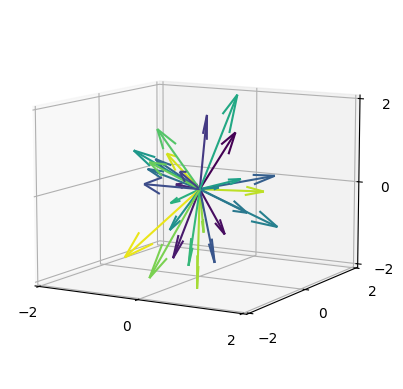

In [29]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Create a PyTorch tensor with shape [100, 3]
# For demonstration, let's use random data
tensor_data = model.field.train_mu[0].cpu().detach()

# rotation = get_rotation(torch.tensor(np.deg2rad(90.0)).float())

# tensor_data = torch.matmul(tensor_data, rotation.T)

# Convert the tensor to a NumPy array
numpy_data = tensor_data.numpy()

# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot N vectors
N = 30  # You can set N to any number up to 100

# The starting points for the vectors (setting all to origin (0, 0, 0))
origin = np.zeros((N, 3))

np.random.seed(0)
colors = [plt.cm.viridis(i/N) for i in range(N)]

# Plotting the vectors
for i in range(N):
    ax.quiver(origin[i, 0], origin[i, 1], origin[i, 2], numpy_data[i, 0], numpy_data[i, 1], numpy_data[i, 2], color=colors[i])

# # Setting axis label
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

# Set axis limits
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_zlim([-2, 2])

# Set axis ticks
ax.set_xticks([-2, 0, 2])
ax.set_yticks([-2, 0, 2])
ax.set_zticks([-2, 0, 2])

ax.view_init(elev=10)  # Set this value to your preference; smaller values will lower the camera.

# Show the plot
plt.savefig('filename.svg', format='svg')